# **FRUIT OBJECT DETECTION USING DEEP LEARNING**

# INSTALL LIBRARIES

In [16]:
! pip install ultralytics

# IMPORT LIBRARY

In [17]:
import os
from ultralytics import YOLO
import xml.etree.ElementTree as ET
import cv2
import glob
import shutil
import random
import albumentations as A
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,average_precision_score
from google.colab.patches import cv2_imshow
from PIL import Image

# PATHS SETUP

In [18]:
train_images_path="/content/drive/MyDrive/Fruit object detection/Train"
test_images_path="/content/drive/MyDrive/Fruit object detection/Test"

In [19]:
project_folder="/content/yolo_fruit"
images_folder=os.path.join(project_folder,"images")
labels_folder=os.path.join(project_folder,"labels")

os.makedirs(os.path.join(images_folder,"train"),exist_ok=True)
os.makedirs(os.path.join(images_folder,"test"),exist_ok=True)
os.makedirs(os.path.join(images_folder,"valid"),exist_ok=True)
os.makedirs(os.path.join(labels_folder,"train"),exist_ok=True)
os.makedirs(os.path.join(labels_folder,"test"),exist_ok=True)
os.makedirs(os.path.join(labels_folder,"valid"),exist_ok=True)

# XML TO YOLO CONVERSION FUNCTION

In [20]:
def convert_xml_to_yolo(xml_file_path,img_width,img_height):
  xml_tree=ET.parse(xml_file_path)
  xml_root=xml_tree.getroot()

  yolo_annotation=[]

  fruit_classes={"apple":0,"banana":1,"orange":2}

  for obj in xml_root.findall("object"):
    class_name=obj.find("name").text
    class_id=fruit_classes[class_name]

    xmin=int(obj.find("bndbox/xmin").text)
    ymin=int(obj.find("bndbox/ymin").text)
    xmax=int(obj.find("bndbox/xmax").text)
    ymax=int(obj.find("bndbox/ymax").text)

    x_center=(xmin+xmax)/2/img_width
    y_center=(ymin+ymax)/2/img_height
    width=(xmax-xmin)/img_width
    height=(ymax-ymin)/img_height
    yolo_annotation.append(f"{class_id} {x_center} {y_center} {width} {height}")
  return yolo_annotation

# SPLIT DATASET(TRAIN/VALID)

In [21]:
image_files=glob.glob("/content/drive/MyDrive/Fruit object detection/Train/*.jpg")
random.shuffle(image_files)

split=int(0.8*len(image_files))
train_images=image_files[:split]
valid_images=image_files[split:]

test_images=glob.glob("/content/drive/MyDrive/Fruit object detection/Test/*.jpg")

print("Train images:",len(train_images))
print("Valid images:",len(valid_images))
print("Test images:",len(test_images))

Train images: 192
Valid images: 48
Test images: 60


# CONVERT AND COPY IMAGES TO YOLO FORMAT

In [22]:
def process_split(image_list,mode):
  for image_path in image_list:
    img=cv2.imread(image_path)
    h,w,_=img.shape

    xml_path=image_path.replace(".jpg",".xml")

    yolo_label=convert_xml_to_yolo(xml_path,img_width=w,img_height=h)

    shutil.copy(image_path,os.path.join(images_folder,mode))
    label_path=os.path.join(labels_folder,mode,os.path.basename(image_path).replace(".jpg",".txt"))
    with open(label_path,"w") as f:
      f.write("\n".join(yolo_label))
process_split(train_images,"train")
process_split(valid_images,"valid")

# DATA AUGMENTATION

In [23]:
transform=A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.3,contrast_limit=0.3,p=0.5),
        A.HueSaturationValue(hue_shift_limit=15,sat_shift_limit=25,val_shift_limit=15,p=0.5),
        A.RandomGamma(gamma_limit=(80,120),p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1,scale_limit=0.2,rotate_limit=15,p=0.5),
        A.Rotate(limit=20,p=0.3),
        A.RandomScale(scale_limit=0.3,p=0.5),
        A.GaussNoise(var_limit=(10.0,40.0),p=0.3),
        A.MedianBlur(blur_limit=3,p=0.3),
        A.CoarseDropout(max_holes=1, max_height=20, max_width=20, p=0.2)
    ],
    bbox_params=A.BboxParams(format='yolo',label_fields=['class_labels'])
)

os.makedirs(os.path.join(images_folder,"train_aug"),exist_ok=True)
os.makedirs(os.path.join(labels_folder,"train_aug"),exist_ok=True)


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-2519656228.py:11: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0,40.0),p=0.3),
/tmp/ipython-input-2519656228.py:13: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=20, max_width=20, p=0.2)


# APPLY AUGMENTATION

In [24]:
img_paths=glob.glob(os.path.join(images_folder,"train","*.jpg"))

for img_path in img_paths:
  txt_path=img_path.replace("images","labels").replace(".jpg",".txt")
  img=cv2.imread(img_path)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

  with open(txt_path,"r") as f:
    lines=f.readlines()
    labels=[]
    bboxes=[]

    for line in lines:
      c,x,y,w,h=map(float,line.strip().split())
      labels.append(int(c))
      bboxes.append([x,y,w,h])

  trans=transform(image=img,bboxes=bboxes,class_labels=labels)
  new_img=trans['image']
  new_bboxes=trans['bboxes']
  new_labels=trans['class_labels']

  new_img_path=img_path.replace("train","train_aug")
  cv2.imwrite(new_img_path,cv2.cvtColor(new_img,cv2.COLOR_RGB2BGR))

  new_txt_path=txt_path.replace("train","train_aug")

  with open(new_txt_path,"w") as f:
    for cls,bbox in zip(new_labels,new_bboxes):
      x,y,w,h=bbox
      f.write(f"{cls} {x} {y} {w} {h}\n")

In [25]:
images_folder = "/content/yolo_fruit/images"
labels_folder = "/content/yolo_fruit/labels"

aug_folder = os.path.join(images_folder, "train_aug")
aug_label_folder = os.path.join(labels_folder, "train_aug")

os.makedirs(aug_folder, exist_ok=True)
os.makedirs(aug_label_folder, exist_ok=True)

banana_imgs = []

for img_path in glob.glob(os.path.join(images_folder, "train", "*.jpg")):
  txt_path = img_path.replace("images", "labels").replace(".jpg", ".txt")
  if not os.path.exists(txt_path):
    continue

  with open(txt_path, "r") as f:
    for line in f:
      cls = int(line.strip().split()[0])
      if cls == 1:
        banana_imgs.append(img_path)
        break

for img_path in banana_imgs:
  txt_path = img_path.replace("images", "labels").replace(".jpg", ".txt")

  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  labels = []
  bboxes = []
  with open(txt_path, "r") as f:
    for line in f:
      cls, x, y, w, h = map(float, line.strip().split())
      labels.append(int(cls))
      bboxes.append([x, y, w, h])

  for i in range(3):
    trans = transform(image=img, bboxes=bboxes, class_labels=labels)
    new_img = trans["image"]
    new_bboxes = trans["bboxes"]
    new_labels = trans["class_labels"]

    base_name = os.path.basename(img_path).replace(".jpg", f"_aug{i}.jpg")
    new_img_path = os.path.join(aug_folder, base_name)
    cv2.imwrite(new_img_path, cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR))

    new_txt_path = os.path.join(aug_label_folder, base_name.replace(".jpg", ".txt"))
    with open(new_txt_path, "w") as f:
      for cls, bbox in zip(new_labels, new_bboxes):
        x, y, w, h = bbox
        f.write(f"{cls} {x} {y} {w} {h}\n")

# CHECK IF GPU IS AVAILABLE

In [26]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# CREATE DATA YAML

In [27]:
data_yaml = """
train:
- /content/yolo_fruit/images/train
- /content/yolo_fruit/images/train_aug

val: /content/yolo_fruit/images/valid

nc: 3
names: ["apple","banana","orange"]
"""

with open("/content/yolo_fruit/data.yaml", "w") as f:
  f.write(data_yaml)

# TRAIN YOLOV8

In [28]:
model = YOLO("yolov8n.pt")
model.train(
    data="/content/yolo_fruit/data.yaml",
    epochs=50,
    batch=8,
    imgsz=640,
    device=device,
    patience=10
)

Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_fruit/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c778f184800>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

# EVALUATE MODEL

In [29]:
metrics=model.val()
print(metrics)

Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1086.8±1027.7 MB/s, size: 69.5 KB)
val: Scanning /content/yolo_fruit/labels/valid.cache... 85 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 85/85 23.8Mit/s 0.0s
val: /content/yolo_fruit/images/valid/apple_62.jpg: corrupt JPEG restored and saved
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 6/6 1.3it/s 4.6s
                   all         85        178      0.981      0.976      0.993      0.858
                 apple         35         64      0.994          1      0.995       0.88
                banana         33         64      0.998      0.969      0.992      0.836
                orange         29         50       0.95       0.96      0.991      0.859
Speed: 8.0ms preprocess, 14.7ms inference, 0.0ms loss, 

In [30]:
summary=metrics.summary()
print(summary)

[{'Class': 'apple', 'Images': np.int64(35), 'Instances': np.int64(64), 'Box-P': np.float64(0.99447), 'Box-R': np.float64(1.0), 'Box-F1': np.float64(0.99723), 'mAP50': np.float64(0.995), 'mAP50-95': np.float64(0.88023)}, {'Class': 'banana', 'Images': np.int64(33), 'Instances': np.int64(64), 'Box-P': np.float64(0.99847), 'Box-R': np.float64(0.96875), 'Box-F1': np.float64(0.98339), 'mAP50': np.float64(0.99162), 'mAP50-95': np.float64(0.83615)}, {'Class': 'orange', 'Images': np.int64(29), 'Instances': np.int64(50), 'Box-P': np.float64(0.94999), 'Box-R': np.float64(0.96), 'Box-F1': np.float64(0.95497), 'mAP50': np.float64(0.99136), 'mAP50-95': np.float64(0.85908)}]


In [31]:
metrics.confusion_matrix.matrix

array([[         64,           0,           0,           5],
       [          0,          63,           0,           4],
       [          0,           0,          50,           5],
       [          0,           1,           0,           0]])

# CUSTOM EVALUATION AND CALCULATE METRICS

In [32]:
def eval_custom(y_true,y_pred_scores):
  auc_roc=roc_auc_score(y_true,y_pred_scores)
  auc_pred=average_precision_score(y_true,y_pred_scores)
  y_pred=(np.array(y_pred_scores)>0.5).astype(int)
  f1=f1_score(y_true,y_pred)

  return auc_roc,auc_pred,f1

y_true=[0,1,1,0,1]
y_pred_scores=[0.1,0.9,0.75,0.2,0.8]

metrics=eval_custom(y_true,y_pred_scores)
print(metrics)

(np.float64(1.0), np.float64(1.0), 1.0)


# PREDICTION ON TEST IMAGE


0: 640x640 1 banana, 7.9ms
Speed: 4.6ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


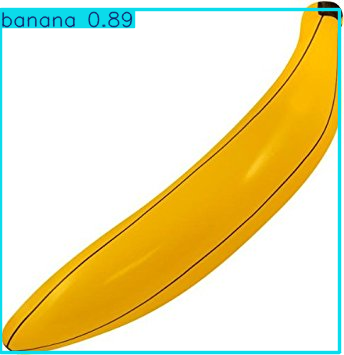

In [33]:
img=cv2.imread(test_images[0])
results=model(img)
out=results[0].plot()

cv2_imshow(out)